In [1]:
import sys
sys.path.append("../../")

import logging
logging.getLogger('tensorflow').disabled = True

import numpy as np
import pandas as pd
from tqdm.keras import TqdmCallback
from pandas.plotting import scatter_matrix
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from transport_nets.models import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
file = h5py.File('BeamSamples.h5','r')
joint_samples = np.array(file['Samples/'],dtype=np.float32)
scaler = MinMaxScaler()
scaled_samples = scaler.fit_transform(joint_samples)

NUM_SAMPLES = joint_samples.shape[0]
BATCH_SIZE = 1000
dataset = tf.data.Dataset.from_tensor_slices(scaled_samples)
dataset = dataset.shuffle(buffer_size=NUM_SAMPLES).batch(BATCH_SIZE)

OUTPUT_DIM = 9
NUM_LAYERS = 10
NUM_MASKED = 5
NEURON_LIST = [200,200]

nvp = NVP(output_dim=OUTPUT_DIM,
          num_layers = NUM_LAYERS,
          num_masked = NUM_MASKED,
          neuron_list = NEURON_LIST)

# Adam optimizer parameters
LR = 1e-3
beta_1 = 0.9
beta_2 = 0.999
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=beta_1, beta_2=beta_2, epsilon=1e-08)
nvp.compile(opt)

N_EPOCHS = 50
# Train the model with the new callback
history = nvp.fit(dataset, epochs=N_EPOCHS, verbose=0, callbacks=[TqdmCallback(verbose=1)])  # Pass callback to training
# Set the training variables to not update when doing passes
nvp.training_mode(False)
nvp.save_weights('models/nvp/weights.h5py')
nvp.save_model('models/nvp/model.h5py')

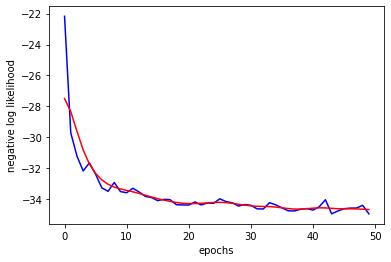

In [3]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('epochs')
plt.ylabel('negative log likelihood');

<Figure size 1080x1080 with 0 Axes>

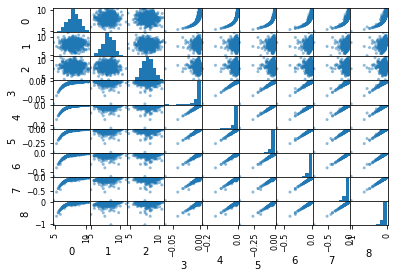

In [4]:
plt.figure(figsize=(15,15))
scatter_matrix(pd.DataFrame(joint_samples[::100,:]))
plt.savefig('images/Euler-Beam-joint-density-samples-scatter.png')
plt.show()

<Figure size 1080x1080 with 0 Axes>

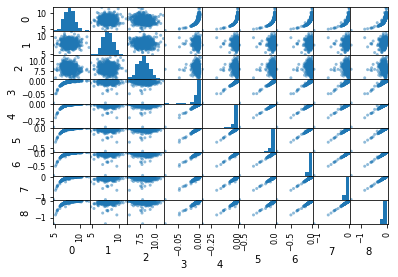

In [5]:
fig = plt.figure(figsize=(15,15))
x_forward = scaler.inverse_transform(nvp.sample(500).numpy())
scatter_matrix(pd.DataFrame(x_forward))
plt.savefig('images/Euler-Beam-joint-density-nvp-scatter.png')
plt.show()

In [7]:
from transport_nets.mcmc import MetropolisHastings
from transport_nets.mcmc import model_log_prob
num_params = 3
test_values = np.array(file['TestValues'],dtype=np.float32)
m_y_scaled = scaler.transform(np.reshape(test_values,(1,-1)))
y_obs = m_y_scaled[0,num_params:]
init_val = 0.5*tf.ones([3],tf.float32)
b = tf.constant(0.04,tf.float32)
niters = 5000
log_prob_fn = model_log_prob(nvp,y_given=y_obs)

samples,acc_rate,time_total = MetropolisHastings(init_val,b,niters,log_prob_fn)

100%|██████████| 5000/5000 [01:01<00:00, 81.92it/s]


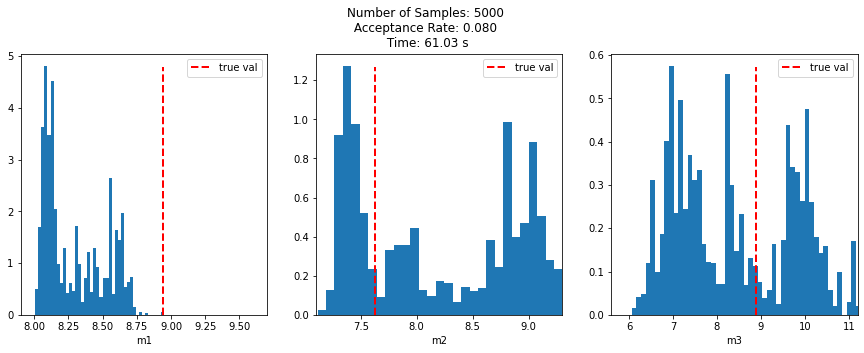

In [8]:
# unscaling sampled parameters (m1,m2,m3)
data_min = scaler.data_min_[:num_params]
data_max = scaler.data_max_[:num_params]
scale = scaler.scale_[:num_params]
samples_unscaled = samples*(data_max-data_min) + data_min

fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(test_values[:num_params])

axs[0].hist(samples_unscaled[:,0],50,density=True)
axs[0].axvline(m1,ymax=0.95,c='r',ls='--',lw=2.0,label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()
axs[0].set(xlim=(7.9,9.7))

axs[1].hist(samples_unscaled[:,1],50,density=True)
axs[1].axvline(m2,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()
axs[1].set(xlim=(7.1,9.3))

axs[2].hist(samples_unscaled[:,2],50,density=True)
axs[2].axvline(m3,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()
axs[2].set(xlim=(5.6,11.2))
plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(niters,acc_rate,time_total))
plt.subplots_adjust(top=0.85)

plt.savefig('images/NVP-MH-Euler_Beam.png')